In [1]:
import cfGPR
import gpr

import numpy as np
import matplotlib.pyplot as plt

Starting in May 2019Ω I have been working with Professor Gary Bernstein on improving astrometric error in DES data. Bernstein 2017 outlines the types of astrometric errors that are seen in the DES data, and all of these have been accounted for to improve the astrometric results apart from one: stochastic error. Our data is composed of three parts. The first is osberved sky position of each star $(x_i, y_i)$. The second is the astrometric residuals $(dx_i, dy_i)$, or error, for each star where $(x_i+dx_i, y_i+dy_i)$ gives the "truth position" of each star obtained by the Gaia satellite. The third part is a measurement error for each star which specifies the random error induced by shot noise in the centroid of the star’s point spread function.

The astrometric residuals are thought to be sourced by a curl-free atmospheric turbulence field that will vary, incoherently, from exposure to exposure. My task has been to fit these errors to a particular type of model called a Gaussian Process Regression (GPR) model; because the turbulence field is also assumed to be a gaussian random field, it makes sense to model it with a Gaussian Process. Rasmussen and Williams (2006) outline the steps for fitting and predicting with a GPR model in Algorithm 2.1.

The GPR model starts with a choice of kernel (or covaraince) function. In our case, we use the sum of a gaussian covariance functions ($K$) and a diagonal, white noise, covariance function ($W$) that represents the measurement error. We then feed this algorithm star positions and astrometric residuals for a handful of stars; the GPR trains on this data. Then we can ask the GPR to predict astrometric residuals based on new star positions; the prediction is called the posterior predictive mean and is straighforward to calculate. The posterior predictive mean will ideally interpolate only the turbulence field and not the shot noise. Therefore, removing this interpolated turbulence field (known as "applying" the model) for stars that Gaia cannot see will allow us to reduce astrometric error as much as we possible can.

The cosmological implications of improving astrometry are immense. For example, there exists streams of stars in the halo of the Milky Way whose orbits can be constructed from their proper motion. This orbital data would give insight into not only galaxy formation and structure but also the gravitational potential of the Milky Way. Additionally, accurate proper motions for main sequence stars and viewable objects in the halo of the Milky Way can help constrain the mass, density, and shape of our dark matter halo. However, the trick to all of this is choosing the best function for $K$ and finding the optimal hyperparameters for $K$.

Since the start of this research there have been two main methods of performing GPR; the Two Kernel Method and the curl-free GPR (cfGPR). The Two Kernel Method is effectively two entirely separate GPR models. One model is used to predict the $dx$ residuals and the other is used predict the $dy$ residuals. Both GPR models use the identical kernel function:

\begin{align}
K(x, y;x', y') = \sigma_{s}^2 \exp{(a(x-x')^2 + 2b(x – x')(y – y') + c(y – y')^2}
\end{align}

where,

\begin{align}
a &= \frac{\cos^2{\phi}}{2 \sigma_x^2} + \frac{\sin^2{\phi}}{2 \sigma_y^2} \\
a &= -\frac{\sin{2\phi}}{4 \sigma_x^2} + \frac{\sin{2\phi}}{4 \sigma_y^2} \\
c &= \frac{\sin^2{\phi}}{2 \sigma_x^2} + \frac{\cos^2{\phi}}{2 \sigma_y^2} \\
\end{align}

but each GPR model was optimized for separately and therefore would not necessarily have the same hyperparameters $\sigma_{s}$, $\sigma_{x}$, $\sigma_{y}$, and $\phi$.

The cfGPR takes advantage of the fact that the turbulence field is expected to be curl-free. To see this, first consider a ray-optic model for atmospheric turbulence where the centroid of a star moves by the vecor $\vec{dx} \equiv (dx, dy)$ as a result of the turbulence. If the optical path difference is given by $\Phi$ then, 

\begin{align}
(dx, dy) &= (\frac{\partial \Phi}{\partial x}, \frac{\partial \Phi}{\partial y}) \\
\vec{dx} &= \vec{\nabla} \cdot \Phi \\
\end{align}

Since the curl of a gradient is always zero, it follows that $\vec{dx}$ must be curl-free. In practice, $\vec{\nabla} \times \vec{dx}$ will contain only white noise consistent with the shot noise of stellar centroid measurements.

The cfGPR assumes that $\Phi$ is a zero-mean Gaussian field, in which case it can be fully characterized by its power spectrum $P_{\Phi}(\vec{k})$ or its  two-point correlation function $K_{\Phi}(\vec{\Delta x})$. With a Fourier convention

\begin{align}
\tilde{f}(\vec{k}) &= \frac{1}{(2 \pi)^2} \int d^2 \vec{x}\ f(\vec{x})\ \exp(-i\vec{k} \cdot \vec{x}) \\
f(\vec{x}) &= \int d^2 \vec{k}\ \tilde{f}(\vec{k})\ \exp(i\vec{k} \cdot \vec{x}),
\end{align}

we can relate the two via the Fourier transform

\begin{align}
K_{\Phi}(\vec{\Delta x}) = \int d^2 \vec{k}\ P_{\Phi}(\vec{k})\ \exp(-i\vec{k} \cdot \vec{\Delta x}).
\end{align}

From the definition of $\vec{dx}$ it follows that $\tilde{dx} = i \vec{k} \tilde{\Phi}$. Therefore, the covariance matrix of of the turbulence component of the displacement field is

\begin{align}
K_t(\vec{\Delta x}) = \int d^2\vec{k}\ (\vec{k} \vec{k}^T)\ P_{\Phi}(\vec{k})\ \exp(-i\vec{k} \cdot \vec{\Delta x}).
\end{align}

Therefore, for any $P_{\Phi}$ we can construct a 2 x 2 covariance function $K_t$ for each $\vec{\Delta x}$. Note that if $K_t$ were diagonal then this method would reduce to Method 1.

To obtain the function form of the kernel, we then assume there is a matrix $S_{\Phi}$ such that

\begin{align}
P_{\Phi}(\vec{k}) = A \exp -\frac{1}{2} (\vec{k}^T \cdot S_{\Phi} \cdot \vec{k}).
\end{align}

Plugging into $K_{\Phi}$

\begin{align}
K_{\Phi}(\vec{\Delta x}) &= \int d^2 \vec{k}\ A \exp -\frac{1}{2} (\vec{k}^T \cdot S_{\Phi} \cdot \vec{k}) \exp(-i\vec{k} \cdot \vec{\Delta x}) \\
&= \frac{2 \pi A}{|S_{\Phi}|} \exp -\frac{1}{2} (\vec{\Delta x}^T \cdot S_{\Phi} \cdot \vec{\Delta x}).
\end{align}

Note that we can write down $K_t$ generally as

\begin{align}
K_t(\vec{\Delta x}) &= -\frac{\partial^2}{\partial \vec{\Delta x}^2} \int d^2\vec{k}\ P_{\Phi}(\vec{k})\ \exp(-i\vec{k} \cdot \vec{\Delta x}) \\
&= -\frac{\partial^2}{\partial \vec{\Delta x}^2} K_{\Phi}(\vec{\Delta x}).
\end{align}

Plugging in the gaussian form of $P_{\Phi}$ above, we can solve for $K_t(\vec{\Delta x})$.

Our actual kernel matrix now becomes $K$ where each element is a block matrix such that $$K_{i,j} = K_t(\vec{x}_i - \vec{x}_j),$$ for stars $i$, $j$. The off-diagonal terms in $K_t$ present new information that the cfGPR can exploit while the Two Kernel Method cannot. This should lead to more accurate interpolation.

In addition to taking advantage of the curl-free nature of the turbulence field, the cfGPR algorithm starts by sigma clipping the dataset to four standard deviations in order to remove extreme outliers. Then the entire dataset is used to calculate the two-dimensional two-point correlation function of total displacement power (see Figure 1). This correlation function is then fit against the trace of $K$ where the parameters that are being fitted for are the four kernel hyperparameters, $\sigma_{s}$, $\sigma_{x}$, $\sigma_{y}$, and $\phi$. This allows us to get a first guess at what the actual kernel hyperparameters are.

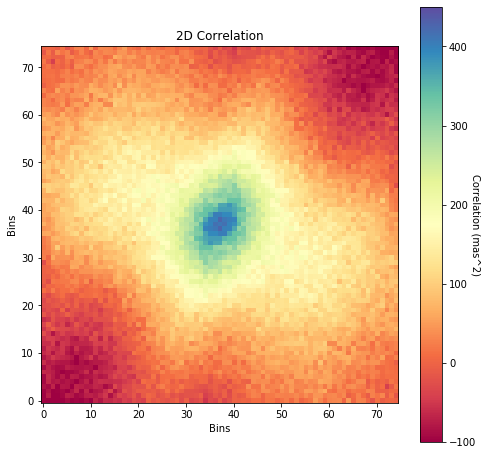

In [2]:
GP = cfGPR.CurlFreeGPR(printing=False)
GP.load_fits('folio2')
GP.extract_data(465)
GP.sigma_clip()
GP.plot_xiplus_2d(GP.X, GP.Y)

Figure 1: (Exposure 465) The two-dimensional two-point correlation function.

This first guess is a good start, but is never optimum. Therefore, after the data is randomly and equally split into a training set and a test set, we then use the Nelder Mead optimizer to find the best solution. Each iteration of the optimizer simply tries to minimize the figure of merit and find the best hyperparameter values by training on the test set and calculating the figure of merit on the test set. We also give the optimizer bounds for each hyperparameter that represent the maximum and minimum physical limitations for each hyperparameter. Although the Nelder Mead Algorithm does not natively accept bounds, we get around this by linearly increasing the figure of merit when a hyperparameter goes out of bounds.

Finally, after the optimizer finds the optimum solution, we can interpolate the turbulence field and subtract it from the dataset (see Figure 2). At this point, we have reached our objective, but all of our methods of performing this interpolation and subtraction do not perform as well as we want them to.

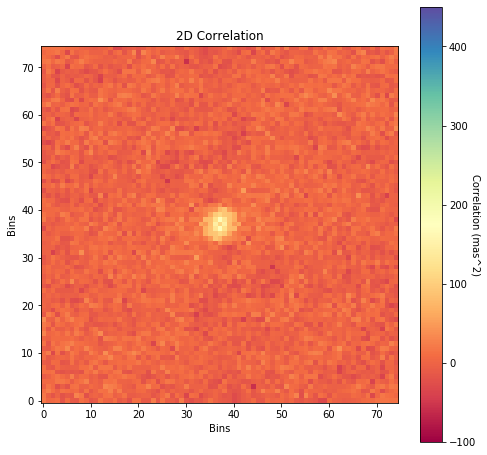

In [3]:
GP.split_data()
GP.correlation_fit()
GP.optimize()
GP.fit(GP.theta)
GP.predict(GP.Xtest)
GP.plot_xiplus_2d(GP.Xtest, GP.Ytest - GP.fbar_s)

Figure 2: (Exposure 465) The two-dimensional two-point correlation function after the turbulence field is interpolated and subtracted (in other words, after the cfGPR is "applied").

Theoretically, the only source of correlation in error between any two stars should be the turbulence field. Therefore, when we look at the correlation function of the astrometric error we would ideally expect there to be no correlation at any separation. However, all of our methods still show some correlation remaining (see Figure 3).

Mean of first 30 points (Emode (Observed)):  435.7637604720614
Mean of first 30 points (Emode (GPR Applied)):  121.17426609066347
Ratio of E modes: 3.5961741261632216
Ratio of B modes: -0.9758657553137728


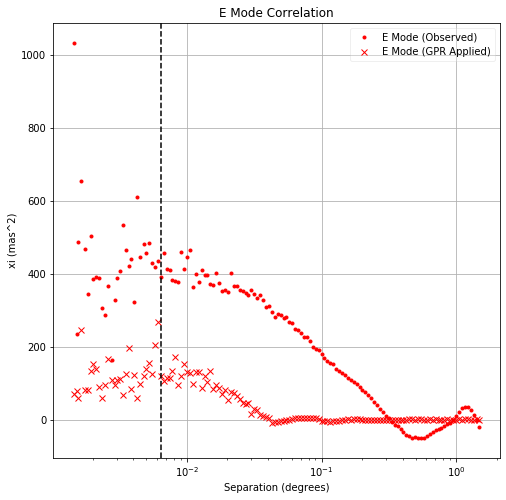

In [4]:
GP.plot_Emode_2ptcorr(GP.Xtest, GP.Ytest, Y2=GP.Ytest - GP.fbar_s, Bmode=False)

Figure 3 (Exposure 465): Angle averaged two-point correlation function (E-modes only) for both observed data (Observed), and for data where the turbulence field has been interpolated and subtracted (GPR Applied). Note that there is less correlation at virtually every separation length.

Our objective now is try to reduce correlation at all separation lengths. After ensuring that the optimizer is doing the best job it can do, the most natural way to try to improve is to improve our guess for $P_\Phi$. By using a more complicated model of turbulence, such as Kolmogorov turbulence, we may be able have more success. Indeed, Pierre-François Léget has tried using this turblence approximation to great success.